# Project 1
### Nicholai L'Esperance

In [1]:
# Imports
from datetime import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import logging

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, f1_score, confusion_matrix, recall_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Read in raw data sources
raw_2016_train = pd.read_csv('train_2016_v2.csv')
raw_2016_property = pd.read_csv('properties_2016.csv')

print(raw_2016_train.shape)
print(raw_2016_property.shape)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(90275, 3)
(2985217, 58)


I used linear regression to impute so many times in this notebook, I decided to wrap it in a function.

In [3]:
def lr_impute(dataset: pd.DataFrame, column_name: str, x_cols: list):
    model = LinearRegression()
    train = dataset[dataset[column_name].notnull()] 
    model.fit(X=train[x_cols], y=train[column_name])
    impute = model.predict(dataset[x_cols])
    return dataset[column_name].fillna(pd.Series(impute, index=dataset.index)), model

## EDA

### a. Determine the number of missing values on each feature.

In [4]:
raw_2016_data = raw_2016_train.merge(raw_2016_property, how='inner', on='parcelid')
print(raw_2016_data.shape)

(90275, 60)


In [5]:
raw_2016_data.isna().sum().sort_values(ascending=False) / raw_2016_data.shape[0] * 100

buildingclasstypeid             99.982276
finishedsquarefeet13            99.963445
basementsqft                    99.952368
storytypeid                     99.952368
yardbuildingsqft26              99.894766
fireplaceflag                   99.754085
architecturalstyletypeid        99.710883
typeconstructiontypeid          99.668790
finishedsquarefeet6             99.533647
decktypeid                      99.271116
poolsizesum                     98.926613
pooltypeid10                    98.713930
pooltypeid2                     98.666297
taxdelinquencyyear              98.024924
taxdelinquencyflag              98.024924
hashottuborspa                  97.380227
yardbuildingsqft17              97.068956
finishedsquarefeet15            96.052063
finishedsquarefeet50            92.405428
finishedfloor1squarefeet        92.405428
fireplacecnt                    89.358073
threequarterbathnbr             86.697314
pooltypeid7                     81.504292
poolcnt                         80

### What parcel ID has the more missing features?

In [6]:
raw_2016_data.loc[raw_2016_data.isna().sum(axis=1).idxmax(), 'parcelid']

17188934

## Rows to Keep

In [7]:
cols_to_keep = ['parcelid', 'logerror', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet6', 
                'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'rawcensustractandblock', 
                'regionidcity', 'regionidcounty', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 
                'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount']
len(cols_to_keep)

28

In [8]:
null_count = raw_2016_data[cols_to_keep].isna().sum(axis=1)
null_count.describe()

count    90275.000000
mean         6.645849
std          1.041990
min          3.000000
25%          6.000000
50%          7.000000
75%          7.000000
max         15.000000
dtype: float64

In [9]:
print(null_count.ge(10).sum())

1139


In [10]:
raw_2016_data = raw_2016_data[null_count.lt(10)]

In [11]:
raw_2016_data.shape

(89136, 60)

### b) Determine the number of cities in each county

In [12]:
raw_2016_data.groupby('regionidcounty').agg({'regionidcity': 'nunique'})

,regionidcity
regionidcounty,
1286.0,43
2061.0,19
3101.0,127


### c) Determine which county has the highest logerror
Let's do this by using the median for each county.

In [13]:
raw_2016_data.groupby('regionidcounty').agg({'logerror': ['median', 'max']})

logerror       
                 median    max
regionidcounty                
1286.0            0.006  3.289
2061.0            0.007  3.018
3101.0            0.005  4.737

So, county 2061 has the highest logerror on average.

### d) There are total of 17 columns containing column names with ‘id’. Referring to the data dictionary, which id’s can be eliminated? Justify your reasons. 

In [14]:
id_cols = [col for col in raw_2016_data if 'id' in col]
print(', '.join(id_cols))

parcelid, airconditioningtypeid, architecturalstyletypeid, buildingclasstypeid, buildingqualitytypeid, decktypeid, heatingorsystemtypeid, pooltypeid10, pooltypeid2, pooltypeid7, propertylandusetypeid, regionidcity, regionidcounty, regionidneighborhood, regionidzip, storytypeid, typeconstructiontypeid


In [15]:
raw_2016_data[id_cols].isna().sum().sort_values(ascending=False) / raw_2016_data.shape[0] * 100

buildingclasstypeid         99.982050
storytypeid                 99.951759
architecturalstyletypeid    99.707189
typeconstructiontypeid      99.664558
decktypeid                  99.261802
pooltypeid10                98.699740
pooltypeid2                 98.649255
pooltypeid7                 81.267950
airconditioningtypeid       67.739185
regionidneighborhood        60.016155
heatingorsystemtypeid       37.126414
buildingqualitytypeid       35.651140
regionidzip                  0.015706
propertylandusetypeid        0.000000
regionidcity                 0.000000
regionidcounty               0.000000
parcelid                     0.000000
dtype: float64

**1)** buildingclasstypeid will be dropped. There are not enough values.  
**2)** storytypeid (same)  
**3)** architecturalstyletypeid (same)  
**4)** typecontructiontypeid (same)  
**5)** decktypeid (same)  
**6-8)** pooltype id cols are mostly useless, but perhaps we can scrape something from these columns along with poolcnt and poolsizesum   
**9)** airconditioningtypeid has enough values we can work with it. It will require a bit of imputation.  
**10)** regionidneighborhood I think will have to go. There are ~500 unique values, and they are not an 'ordered' column. If we don't mind 500 features from this column alone, we can try keeping it, but it would blow up our feature space.  
**11** buildingqualitytypeid we can attempt to imput this, this is actually a 'continuous' variable.  
**12)** heatingorsystemtypeid will definitely be kept. Has significant value to the price of a house (from prior knowledge) and is not missing many values.  
**13)** regionidzip we can get rid of, we can just use city/county instead.  
**14)** propertylandusetypeid we will keep, as it can greatly affect home value.  
**15)** regionidcity we can keep, it could contain good information  
**16)** regionidcounty we can keep, it could contain good information  
**17)** parcelid is just our index, we will not use it as a feature  

### e) Determine the correlations between the size and the room numbers. Are there any ways you can fill in NaN using the correlations?  
By size, I think we're referring to finishedsquarefeet6, finishedsquarefeet12, and calculatedfinishedsquarefeet; our total area, finished living area, and calculated finished area, respectively.  

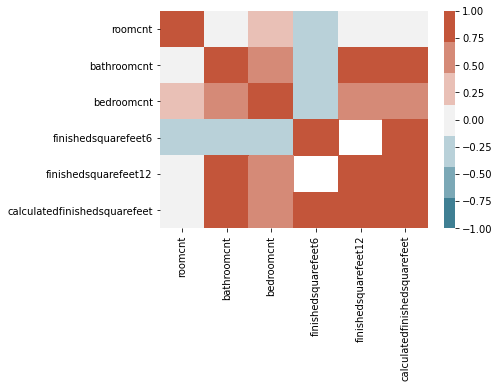

In [16]:
columns = ['roomcnt', 'bathroomcnt', 'bedroomcnt', 'finishedsquarefeet6', 'finishedsquarefeet12', 'calculatedfinishedsquarefeet']
sns.heatmap(raw_2016_data[columns].corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(220, 20, n=7))

Interestingly, there is almost zero correlation between roomcnt and finishedsquarefeet12, while there is a slight correlation between roomcnt and finishedsquarefeet6. We can impute the finishedsquarefeet columns as a function of the two columns each here is correlated with. I'll use a simple linear regression for each. Before we impute, we can take a look at the distributions of each. Calculated square footage is redundant with finishedsqft12, so we will drop one of them.

Text(0.5, 1.0, 'Distribution of calculatedfinishedsquarefeet')

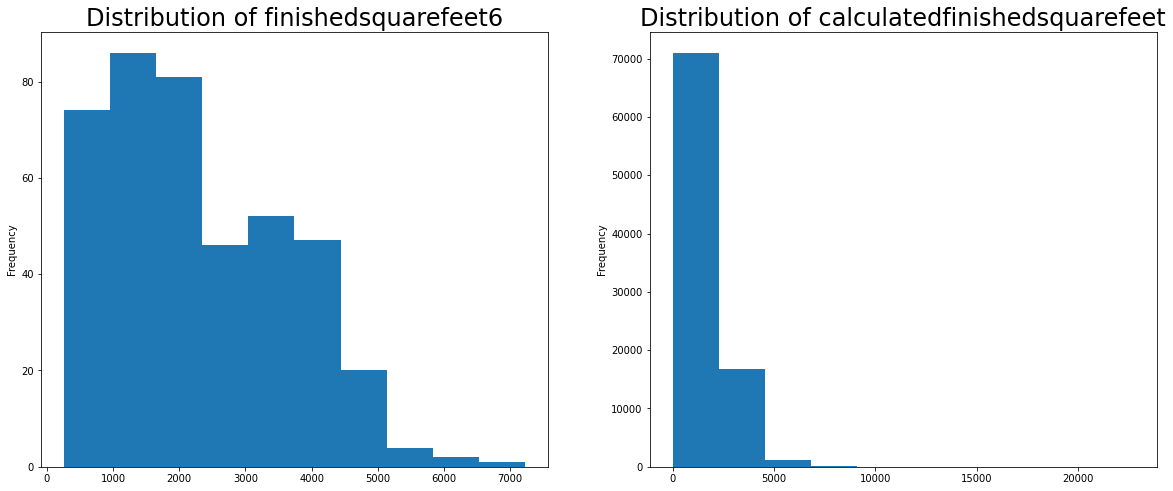

In [17]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))
raw_2016_data['finishedsquarefeet6'].plot(kind='hist', ax=ax0)
ax0.set_title('Distribution of finishedsquarefeet6', fontsize=24)
raw_2016_data['calculatedfinishedsquarefeet'].plot(kind='hist', ax=ax1)
plt.title('Distribution of calculatedfinishedsquarefeet', fontsize=24)

In [18]:
raw_2016_data['finishedsquarefeet6'], fsqft6_model = lr_impute(raw_2016_data, 'finishedsquarefeet6', ['roomcnt', 'bedroomcnt'])
raw_2016_data['calculatedfinishedsquarefeet'], calcsqft_model = lr_impute(raw_2016_data, 'calculatedfinishedsquarefeet', ['bathroomcnt', 'bedroomcnt'])

### After you fill-in, make histrograms and observe if such method is meaningful. Explain how the new correlation changed after you fill-in NaN from the correlation. Did it improve?

Text(0.5, 1.0, 'Distribution of imputed calculatedfinishedsquarefeet')

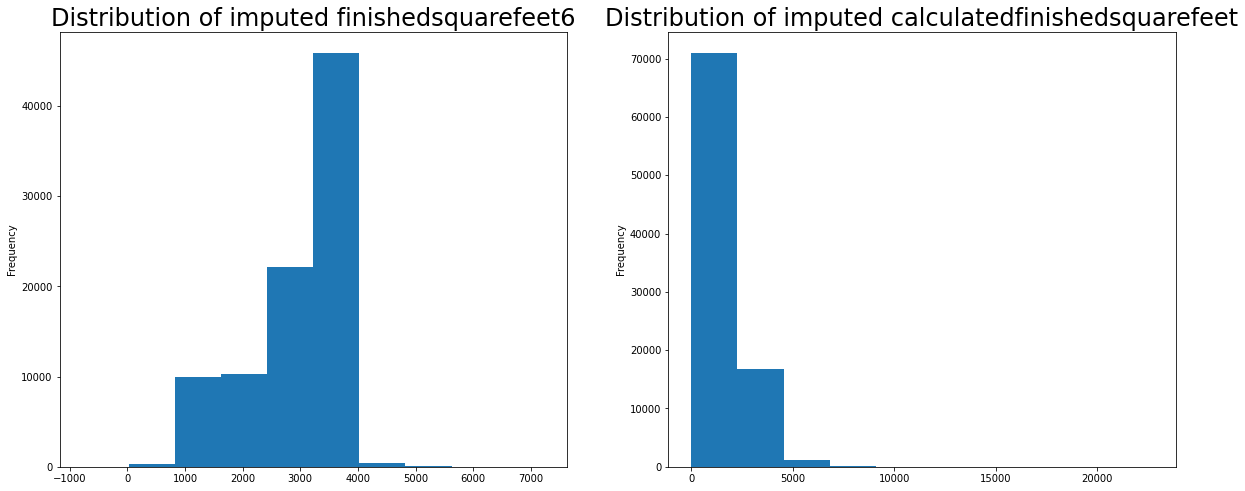

In [19]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))
raw_2016_data['finishedsquarefeet6'].plot(kind='hist', ax=ax0)
ax0.set_title('Distribution of imputed finishedsquarefeet6', fontsize=24)
raw_2016_data['calculatedfinishedsquarefeet'].plot(kind='hist', ax=ax1)
ax1.set_title('Distribution of imputed calculatedfinishedsquarefeet', fontsize=24)

Silly me, I didn't realize that finishedsquarefeet6 was 99% missing. Notice how the distribution for this histogram changed so wildly. I will drop this column in its entirety. The finishedsquarefeet12 column appears to have been imputed well, the hisogram did not change much.

### f) Determine if the roomcnt is the sum of all room features, bedroomcnt and bathroomcnt.

In [20]:
room_cols = [col for col in raw_2016_data.columns if 'room' in col]
room_cols

['bathroomcnt', 'bedroomcnt', 'roomcnt']

In [21]:
room_diff = raw_2016_data['roomcnt'] - raw_2016_data['bedroomcnt'] - raw_2016_data['bathroomcnt']

In [22]:
room_diff.describe()

count    89136.000000
mean        -3.868297
std          3.234974
min        -26.000000
25%         -6.000000
50%         -5.000000
75%         -2.000000
max          9.000000
dtype: float64

Interestingly, there are almost always more bedrooms+bathrooms than there are rooms in 'roomcnt'. I wonder what percentage of houses have strictly more bedroomcnt and bathroomcnt than roomcnt...

In [23]:
print(f'Percent of parcels with bedroom+bathroom > roomcnt: {room_diff.lt(0).sum() / room_diff.shape[0] * 100:0.2f}%')

Percent of parcels with bedroom+bathroom > roomcnt: 78.14%


### g. After you investigate more, delete features and rows that do not carry enough information and report the final dimension of the dataframe.

In [24]:
to_drop = set()

#### Calculate threequarterbath and fullbath from the other columns as best we can

In [25]:
raw_2016_data.loc[raw_2016_data['threequarterbathnbr'].isnull() &
                  raw_2016_data['fullbathcnt'].isnull(), 'fullbathcnt'] = raw_2016_data.loc[raw_2016_data['threequarterbathnbr'].isnull() &
                                                                                            raw_2016_data['fullbathcnt'].isnull(), 'bathroomcnt']

raw_2016_data['threequarterbathnbr'] = np.where(raw_2016_data['threequarterbathnbr'].isnull(), 
                                                (raw_2016_data['bathroomcnt'] - raw_2016_data['fullbathcnt']) * 2,
                                                raw_2016_data['threequarterbathnbr'])

While we are at it, lets impute calculatedbathnbr using a linear model based on correlated columns. We could possibly throw this out as redundant, but we can keep it for now.

In [26]:
raw_2016_data.drop(columns=to_drop).corr().loc['calculatedbathnbr'].sort_values(ascending=False)[:10]

bathroomcnt                     1.000000
calculatedbathnbr               1.000000
fullbathcnt                     0.984074
finishedsquarefeet12            0.805033
calculatedfinishedsquarefeet    0.800752
finishedsquarefeet15            0.700673
bedroomcnt                      0.616599
structuretaxvaluedollarcnt      0.612251
taxvaluedollarcnt               0.497892
finishedfloor1squarefeet        0.491804
Name: calculatedbathnbr, dtype: float64

Nevermind, this column is 100% redundant. We will drop it.

In [27]:
to_drop.add('calculatedbathnbr')

#### Pool count is just a 1/0, but all the zeros are nans. We can fill those with zero. We will impute pool size with the median.

In [28]:
print(raw_2016_data.poolcnt.unique())

[nan  1.]


In [29]:
median_pool_sqft = raw_2016_data['poolsizesum'].median()
raw_2016_data['poolcnt'] = raw_2016_data['poolcnt'].fillna(0)
raw_2016_data['poolsizesum'] = np.where(raw_2016_data['poolsizesum'].isna(), 
                                        raw_2016_data['poolcnt'] * median_pool_sqft, 
                                        raw_2016_data['poolsizesum'])
raw_2016_data['spa_hottub'] = raw_2016_data['pooltypeid2'].astype(bool) | raw_2016_data['pooltypeid10'].astype(bool) | raw_2016_data['hashottuborspa'].astype(bool)

to_drop.update(['pooltypeid10', 'pooltypeid2', 'pooltypeid7'])

#### Assume that missing garagecarcnt is simply houses without garages. We can impute the garage sqft as well, based on numer of cars.

In [30]:
print(raw_2016_data.garagecarcnt.unique())

[nan  2.  1.  3.  0.  4.  6.  8.  5.  7. 11. 10. 24.  9. 13. 14.]


In [31]:
raw_2016_data['garagecarcnt'] = raw_2016_data['garagecarcnt'].fillna(0)

# Now, lets fill missing square footage by the mean sqft/bay. First, we notice some listings have sqft=0, despite having 1+ car locations. We wipe these.
raw_2016_data.loc[raw_2016_data['garagecarcnt'].ge(1) &
                  raw_2016_data['garagetotalsqft'].eq(0), 'garagetotalsqft'] = np.NaN

# Grab the mean square footage per car
valid_garage = raw_2016_data[raw_2016_data['garagecarcnt'].ge(1) &
                             raw_2016_data['garagetotalsqft'].gt(0)]
ave_sq_ft_per_car = valid_garage['garagetotalsqft'].sum() / valid_garage['garagecarcnt'].sum()

# Fill the NaN/None values scaled by num cars
raw_2016_data['garagetotalsqft'] = raw_2016_data.garagetotalsqft.fillna(raw_2016_data.garagecarcnt*ave_sq_ft_per_car)

#### Air conditioning is tricky. We need to convert the ID into a usable form

AirConditioningTypeID	AirConditioningDesc  
1	Central  
2	Chilled Water  
3	Evaporative Cooler  
4	Geo Thermal  
5	None  
6	Other  
7	Packaged AC Unit  
8	Partial  
9	Refrigeration  
10	Ventilation  
11	Wall Unit  
12	Window Unit  
13	Yes  

In [32]:
raw_2016_data['airconditioningtypeid'] = raw_2016_data['airconditioningtypeid'].fillna(5)

# I am going to attempt to make a new feature, 'advanced_ac', to capture the perceived more premium AC systems.
raw_2016_data['has_airconditioning'] = raw_2016_data['airconditioningtypeid'].ne(5).astype(int)
raw_2016_data['advanced_ac'] = raw_2016_data['airconditioningtypeid'].isin((2,3,4,9)).astype(int)

ac_dummies = pd.get_dummies(raw_2016_data['airconditioningtypeid'])
ac_dummies.columns = "ac_id__" + ac_dummies.columns.astype(int).astype(str)

to_drop.add('airconditioningtypeid')

#### Heating is similar to AC.

HeatingOrSystemTypeID	HeatingOrSystemDesc  
1	Baseboard  
2	Central  
3	Coal  
4	Convection  
5	Electric  
6	Forced air  
7	Floor/Wall  
8	Gas  
9	Geo Thermal  
10	Gravity  
11	Heat Pump  
12	Hot Water  
13	None  
14	Other   
15	Oil  
16	Partial  
17	Propane  
18	Radiant  
19	Steam    
20	Solar  
21	Space/Suspended  
22	Vent   
23	Wood Burning  
24	Yes  
25	Zone!

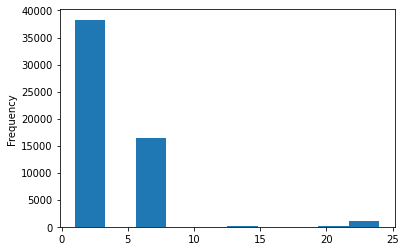

In [33]:
raw_2016_data['heatingorsystemtypeid'].plot(kind='hist')

#### Rather than impute with just one value, because we don't have any good strong correlations, I'm going to impute randomly using the distribution above.

In [34]:
heat_dist_dict = (raw_2016_data['heatingorsystemtypeid'].value_counts() / raw_2016_data['heatingorsystemtypeid'].notnull().sum()).to_dict()
heat_impute = np.random.choice(a=list(heat_dist_dict.keys()), p=list(heat_dist_dict.values()), size=raw_2016_data['heatingorsystemtypeid'].isna().sum())

# I will engineer a few extra featuers as well, of what I think might be valuable
raw_2016_data.loc[raw_2016_data['heatingorsystemtypeid'].isna(), 'heatingorsystemtypeid'] = heat_impute
raw_2016_data['has_heat'] = raw_2016_data['airconditioningtypeid'].eq(1) | raw_2016_data['heatingorsystemtypeid'].eq(2).astype(int)
raw_2016_data['central_air'] = raw_2016_data['airconditioningtypeid'].eq(1) | raw_2016_data['heatingorsystemtypeid'].eq(2).astype(int)

heat_dummies = pd.get_dummies(raw_2016_data['heatingorsystemtypeid'])
heat_dummies.columns = "heating_id__" + heat_dummies.columns.astype(int).astype(str)

to_drop.add('heatingorsystemtypeid')

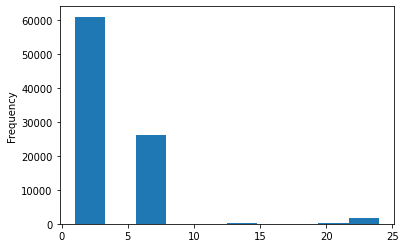

In [35]:
# Now, verify our distribution has not changed:
raw_2016_data['heatingorsystemtypeid'].plot(kind='hist')

### Finally, we can check out buildingqualityid

In [36]:
raw_2016_data['buildingqualitytypeid'].value_counts()

7.0     29307
4.0     23836
1.0      2627
10.0     1461
12.0      119
8.0         5
6.0         2
11.0        1
Name: buildingqualitytypeid, dtype: int64

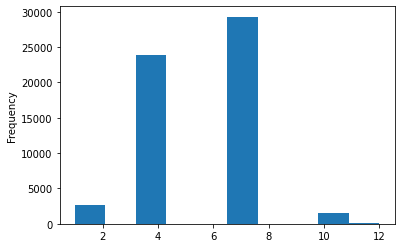

In [37]:
raw_2016_data['buildingqualitytypeid'].plot(kind='hist')

This looks normally distributed, so I will imput with the mean.

In [38]:
raw_2016_data['buildingqualitytypeid'] = raw_2016_data['buildingqualitytypeid'].fillna(raw_2016_data['buildingqualitytypeid'].mean())

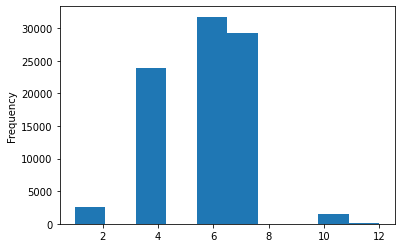

In [39]:
raw_2016_data['buildingqualitytypeid'].plot(kind='hist')

This imputation looks very good to me.

### Let's clean up our data some, and determine what still needs imputation.

In [40]:
to_drop.update(['finishedsquarefeet6', 'finishedsquarefeet12', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 'decktypeid', 'regionidneighborhood', 'fips', 'regionidzip'])

In [41]:
missing = raw_2016_data.drop(columns=to_drop).isna().sum().sort_values(ascending=False) / raw_2016_data.shape[0] * 100
missing[missing.gt(0)]

finishedsquarefeet13          99.997756
basementsqft                  99.951759
yardbuildingsqft26            99.893421
fireplaceflag                 99.750942
architecturalstyletypeid      99.707189
taxdelinquencyflag            98.017636
taxdelinquencyyear            98.017636
hashottuborspa                97.348995
yardbuildingsqft17            97.031502
finishedsquarefeet15          96.017322
finishedfloor1squarefeet      92.309505
finishedsquarefeet50          92.309505
fireplacecnt                  89.232185
numberofstories               76.933001
propertyzoningdesc            34.999327
unitcnt                       34.565159
lotsizesquarefeet             10.579339
censustractandblock            0.261398
yearbuilt                      0.088629
structuretaxvaluedollarcnt     0.072922
taxamount                      0.003366
propertycountylandusecode      0.001122
landtaxvaluedollarcnt          0.001122
taxvaluedollarcnt              0.001122
dtype: float64

I'm going to drop all of the columns that are about 90% missing as well. We can always go back to try and do imputation on them if we think there is information there we want.

In [42]:
to_drop.update(['finishedsquarefeet13', 'basementsqft', 'yardbuildingsqft26', 'fireplaceflag', 'architecturalstyletypeid', 'taxdelinquencyyear', 
                'taxdelinquencyflag', 'hashottuborspa', 'yardbuildingsqft17', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedfloor1squarefeet', 
                'fireplacecnt'])

In [43]:
missing = raw_2016_data.drop(columns=to_drop).isna().sum().sort_values(ascending=False) / raw_2016_data.shape[0] * 100
missing[missing.gt(0)]

numberofstories               76.933001
propertyzoningdesc            34.999327
unitcnt                       34.565159
lotsizesquarefeet             10.579339
censustractandblock            0.261398
yearbuilt                      0.088629
structuretaxvaluedollarcnt     0.072922
taxamount                      0.003366
propertycountylandusecode      0.001122
landtaxvaluedollarcnt          0.001122
taxvaluedollarcnt              0.001122
dtype: float64

### Let's check out year built

In [44]:
print(raw_2016_data['yearbuilt'].mean())
print(raw_2016_data['yearbuilt'].median())
raw_2016_data.drop(columns=to_drop).corr().loc['yearbuilt'].sort_values(ascending=False)[:10]

1968.4291521160605
1970.0


yearbuilt                1.000000
bathroomcnt              0.373773
propertylandusetypeid    0.351078
central_air              0.333354
has_heat                 0.333354
numberofstories          0.331543
fullbathcnt              0.326989
has_airconditioning      0.325839
garagetotalsqft          0.320925
garagecarcnt             0.313872
Name: yearbuilt, dtype: float64

There are no strong correlations here, and coupling that with me not *expecting* there to be a strong relationship outside of random variance, I am going to impute with the mean.

In [45]:
raw_2016_data['yearbuilt'] = raw_2016_data['yearbuilt'].fillna(raw_2016_data['yearbuilt'].mean())

### Tackling the unitcnt column

In [46]:
raw_2016_data['unitcnt'].value_counts()

1.0      54496
2.0       2342
4.0        867
3.0        615
6.0          1
5.0          1
9.0          1
11.0         1
143.0        1
70.0         1
Name: unitcnt, dtype: int64

In [47]:
raw_2016_data.drop(columns=to_drop).corr().loc['unitcnt'].sort_values(ascending=False)[:10]

unitcnt                         1.000000
numberofstories                 0.306778
bedroomcnt                      0.182628
calculatedfinishedsquarefeet    0.145825
rawcensustractandblock          0.123502
censustractandblock             0.122133
bathroomcnt                     0.120496
fullbathcnt                     0.120489
buildingqualitytypeid           0.077071
parcelid                        0.072932
Name: unitcnt, dtype: float64

Again, there are no very strong correlations, and this data is very, very skewed towards unitcnt=1. I am going to impute with 1.

In [48]:
raw_2016_data['unitcnt'] = raw_2016_data['unitcnt'].fillna(1)

### Let's take a look at number of stories. 
First, is there any semblance of valuable data?

In [49]:
raw_2016_data['numberofstories'].value_counts()

1.0    12009
2.0     8043
3.0      507
4.0        2
Name: numberofstories, dtype: int64

This looks good. Lets build another linear model based on the highest correlations, and impute with a prediction.

In [50]:
raw_2016_data.drop(columns=to_drop).corr().loc['numberofstories'].sort_values(ascending=False)[:10]

numberofstories                 1.000000
threequarterbathnbr             0.410750
calculatedfinishedsquarefeet    0.346947
yearbuilt                       0.331367
bathroomcnt                     0.321464
roomcnt                         0.243330
structuretaxvaluedollarcnt      0.222860
fullbathcnt                     0.209900
garagetotalsqft                 0.165906
bedroomcnt                      0.151008
Name: numberofstories, dtype: float64

In [51]:
x_cols = ['threequarterbathnbr', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'yearbuilt', 'bathroomcnt', 'unitcnt']
raw_2016_data['numberofstories'], stories_model = lr_impute(raw_2016_data, 'numberofstories', x_cols)

### There are only a few columns left to fill in. Lets take a look at propertyzoningdesc

In [52]:
print(raw_2016_data['propertyzoningdesc'].nunique())
print(raw_2016_data['propertyzoningdesc'].unique()[:5])

1986
['LARS' nan 'PSR6' 'LAR3' 'HBR3YY']


We have close to 2000 distinct values, and I don't really understand how they are ordered or what they mean. we can drop this column.

In [53]:
to_drop.add('propertyzoningdesc')

### propertylandusetypeid

In [54]:
raw_2016_data['propertylandusetypeid'].unique()

array([261., 266., 265., 246., 263., 269., 248., 247., 267., 260.,  31.,
       264., 275.,  47.])

This column is not missing any values, but it is not a numerical column as far as I can tell. We will make dummies out of this.

In [55]:
land_use_dummies = pd.get_dummies(raw_2016_data['propertylandusetypeid'])
land_use_dummies.columns = "land_use_id__" + land_use_dummies.columns.astype(int).astype(str)

to_drop.add('propertylandusetypeid')

### propertycountylandusecode

In [56]:
raw_2016_data['propertycountylandusecode'].unique()

array(['0100', '1', '010C', '122', '1129', '34', '1128', '010E', '0104',
       '0101', '0200', '0700', '1111', '01DC', '010D', '1110', '0400',
       '012C', '1116', '01HC', '010G', '0300', '010F', '0103', '38',
       '1210', '0111', '010M', '96', '135', '0108', '0201', '0109',
       '1310', '010H', '1410', '010V', '1222', '1720', '1321', '1432',
       '0401', '0102', '012D', '1011', '105', '0110', '0130', '0303',
       '0210', '1333', '0114', '020G', '040A', '012E', '1117', '020M',
       '070D', '1200', '030G', '1722', '1421', '010', nan, '200', '1420',
       '0131', '0301'], dtype=object)

This column is not missing any values, but it is not a numerical column as far as I can tell. I don't want this many dummies, so I am scrapping it for now.

In [57]:
to_drop.add('propertycountylandusecode')

### lotsizesquarefeet

In [58]:
(raw_2016_data['lotsizesquarefeet']/1000).describe()

count    79706.000000
mean        28.859626
std        120.729286
min          0.167000
25%          5.711250
50%          7.200000
75%         11.677750
max       6971.010000
Name: lotsizesquarefeet, dtype: float64

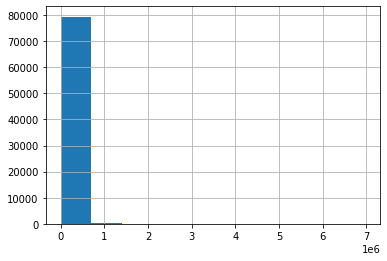

In [59]:
raw_2016_data['lotsizesquarefeet'].hist()

It looks like this column has an outlier. I would like to disinclude this value when determining our imputation. I'll use the 5% to 95% range.

In [60]:
lower = raw_2016_data['lotsizesquarefeet'].quantile(0.05)
upper = raw_2016_data['lotsizesquarefeet'].quantile(0.95)
filtered = raw_2016_data[raw_2016_data['lotsizesquarefeet'].ge(lower) & 
                         raw_2016_data['lotsizesquarefeet'].le(upper)]
filtered.drop(columns=to_drop).corr().loc['lotsizesquarefeet'].sort_values(ascending=False)[:10]

lotsizesquarefeet             1.000000
has_airconditioning           0.312073
yearbuilt                     0.235879
poolsizesum                   0.231425
poolcnt                       0.229378
has_heat                      0.186759
central_air                   0.186759
regionidcounty                0.173185
latitude                      0.146323
structuretaxvaluedollarcnt    0.108838
Name: lotsizesquarefeet, dtype: float64

In [61]:
x_cols = ['has_airconditioning', 'yearbuilt', 'poolsizesum']
raw_2016_data['lotsizesquarefeet'], lotsqft_model = lr_impute(raw_2016_data, 'lotsizesquarefeet', x_cols)

### censustractandblock

In [62]:
raw_2016_data.drop(columns=to_drop).corr().loc['censustractandblock'].sort_values(ascending=False)[:10]

censustractandblock             1.000000
rawcensustractandblock          0.999835
garagecarcnt                    0.718500
garagetotalsqft                 0.715248
roomcnt                         0.710329
parcelid                        0.674548
threequarterbathnbr             0.400933
yearbuilt                       0.243029
numberofstories                 0.188863
calculatedfinishedsquarefeet    0.061369
Name: censustractandblock, dtype: float64

This has 99.9% correlation with rawcensustractandblock. Dropping this column.

In [63]:
to_drop.add('censustractandblock')

### Tax columns

There are a number of tax columns that are all correlated with each other, but are missing values. I am going to impute the values with the least number of missing rows, and then impute the rest based on that.

In [64]:
x_cols = ['calculatedfinishedsquarefeet', 'bathroomcnt']
raw_2016_data['taxvaluedollarcnt'], tax_model0 = lr_impute(raw_2016_data, 'taxvaluedollarcnt', x_cols)

raw_2016_data['landtaxvaluedollarcnt'], tax_model1 = lr_impute(raw_2016_data, 'landtaxvaluedollarcnt', ['taxvaluedollarcnt'] + x_cols)
raw_2016_data['structuretaxvaluedollarcnt'], tax_model2 = lr_impute(raw_2016_data, 'structuretaxvaluedollarcnt', ['taxvaluedollarcnt', 'landtaxvaluedollarcnt'] + x_cols)
raw_2016_data['taxamount'], tax_model3 = lr_impute(raw_2016_data, 'taxamount', ['taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt'] + x_cols)

### Finally, lets change the transaction date to a numerical column we can actually use. This will be a feature we can learn on, and will affect how we split our data.

In [65]:
date_int = pd.to_datetime(raw_2016_data['transactiondate']).astype(int)
# We now can shave off the 11 unchanging zeros on the end of our datetime objects. These represenect hours/minutes/seconds
raw_2016_data['date_numeric'] = date_int.astype(str).str[:-11].astype(int)

to_drop.add('transactiondate')

## Finalizing our dataset

In [66]:
final_2016_data = pd.concat((raw_2016_data.drop(columns=to_drop), heat_dummies, ac_dummies, land_use_dummies), axis=1).set_index('parcelid').sort_values('date_numeric')
final_2016_data.head()

,logerror,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,...,land_use_id__248,land_use_id__260,land_use_id__261,land_use_id__263,land_use_id__264,land_use_id__265,land_use_id__266,land_use_id__267,land_use_id__269,land_use_id__275
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,2.0,3.0,4.000000,1684.0,2.0,0.0,0.0,34280990.0,-118488536.0,...,0,0,1,0,0,0,0,0,0,0
14366692,-0.1684,3.5,4.0,5.565414,2263.0,3.0,2.0,468.0,33668120.0,-117677556.0,...,0,0,1,0,0,0,0,0,0,0
12098116,-0.0040,3.0,2.0,4.000000,2217.0,3.0,0.0,0.0,34136312.0,-118175032.0,...,0,0,1,0,0,0,0,0,0,0
12643413,0.0218,2.0,2.0,4.000000,839.0,2.0,0.0,0.0,33755800.0,-118309000.0,...,0,0,0,0,0,0,1,0,0,0
14432541,-0.0050,2.5,4.0,5.565414,2283.0,2.0,2.0,598.0,33485643.0,-117700234.0,...,0,0,1,0,0,0,0,0,0,0


In [67]:
print(final_2016_data.shape)

(89136, 64)


So, with all the dummies, we have 66 features and 90,275 samples.

## Train/Test Split

Because I made transaction date an integer feature, splitting on 10/15/2016 requires an extra step.

In [68]:
split_date_int = int(dt(2016, 10, 15).timestamp()/100)

y_col = 'logerror'
X_cols = [col for col in final_2016_data.columns if col != y_col]

X_train = final_2016_data.loc[final_2016_data.date_numeric.lt(split_date_int), X_cols]
y_train = final_2016_data.loc[final_2016_data.date_numeric.lt(split_date_int), y_col]

X_test = final_2016_data.loc[final_2016_data.date_numeric.ge(split_date_int), X_cols]
y_test = final_2016_data.loc[final_2016_data.date_numeric.ge(split_date_int), y_col]

Because we need to break this data into five folds for different tests, we will again do this splitting by the transaction date. This will help isolate our folds from each other. The data is already sorted by date, so I'll split into five chunks

In [69]:
n_per_fold = int(X_train.shape[0] / 5)
five_fold_data = [(X_train.iloc[fold*n_per_fold: (fold+1)*n_per_fold], 
                   y_train.iloc[fold*n_per_fold: (fold+1)*n_per_fold]) for fold in range(5)]

### a. One the 1st sample - Do a normal linear regression. Report MSE value.

I will train each model on 4/5 of the folds, and report the MSE of the last fold.

In [70]:
k = 0
fold_train_X = pd.concat([five_fold_data[n][0] for n in range(5) if n!=k])
fold_train_y = pd.concat([five_fold_data[n][1] for n in range(5) if n!=k])

fold_test_X = five_fold_data[k][0]
fold_test_y = five_fold_data[k][1]

lr = LinearRegression()
lr.fit(fold_train_X, fold_train_y)
predict = lr.predict(fold_test_X)
mse = mean_squared_error(fold_test_y, predict)

print(f'Simple Linear Regression (all features) MSE: {mse}')

Simple Linear Regression (all features) MSE: 0.03362757685177706


### b. 2nd sample - make the lasso penalty, l1 and predict logerror. Report MSE value. 

In [71]:
k = 1
fold_train_X = pd.concat([five_fold_data[n][0] for n in range(5) if n!=k])
fold_train_y = pd.concat([five_fold_data[n][1] for n in range(5) if n!=k])

fold_test_X = five_fold_data[k][0]
fold_test_y = five_fold_data[k][1]

lasso = Lasso(alpha=0.75, max_iter=5000)  # default 1000 'did not converge'
lasso.fit(fold_train_X, fold_train_y)
predict = lasso.predict(fold_test_X)
mse = mean_squared_error(fold_test_y, predict)

print(f'Lasso (all features) MSE: {mse}')

Lasso (all features) MSE: 0.02513413191639093


### c. 3rd sample - Use the result of 2nd validation and reduce the number of features.

To do this, we can look at the coefficients of the lasso model.

In [72]:
lasso.coef_

array([ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  7.59709175e-06,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  1.00340274e-09,
       -1.92802254e-09,  9.20765236e-09, -0.00000000e+00, -0.00000000e+00,
       -3.02802577e-09,  1.61780376e-22,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.62178362e-08,  2.54317681e-08,  0.00000000e+00,  0.00000000e+00,
       -3.19228212e-06,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.97475769e-09,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

This model only has nine non-zero coefficients. We can use this to determine what our reduced feature set might look like.

In [73]:
features = fold_train_X.columns[lasso.coef_ != 0].tolist()
print(len(features))
print(', '.join(features))

10
calculatedfinishedsquarefeet, latitude, longitude, lotsizesquarefeet, rawcensustractandblock, regionidcity, structuretaxvaluedollarcnt, taxvaluedollarcnt, taxamount, date_numeric


It looks like this model is content with only 10 features. Looking at them, this seems to make sense. We have four basic variables included in these 10 features: house size, house value (based on taxes), location information, and time.

In [74]:
k = 2
fold_train_X = pd.concat([five_fold_data[n][0] for n in range(5) if n!=k])[features]
fold_train_y = pd.concat([five_fold_data[n][1] for n in range(5) if n!=k])

fold_test_X = five_fold_data[k][0][features]
fold_test_y = five_fold_data[k][1]

for alpha in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8):
    lasso = Lasso(alpha=alpha, max_iter=10000)  # default 1000 'did not converge'
    lasso.fit(fold_train_X, fold_train_y)
    predict = lasso.predict(fold_test_X)
    mse = mean_squared_error(fold_test_y, predict)

    print(f'Lasso (reduced features, alpha={alpha}) MSE: {mse}')

Lasso (reduced features, alpha=0.1) MSE: 0.02325754577302926
Lasso (reduced features, alpha=0.2) MSE: 0.023257635686943307
Lasso (reduced features, alpha=0.3) MSE: 0.023257787288435847
Lasso (reduced features, alpha=0.4) MSE: 0.023258000577506873
Lasso (reduced features, alpha=0.5) MSE: 0.023258275554156407
Lasso (reduced features, alpha=0.6) MSE: 0.02325861221838443
Lasso (reduced features, alpha=0.7) MSE: 0.02325901057019095
Lasso (reduced features, alpha=0.8) MSE: 0.023259470609575963


### d. 4th sample - Using the ridge regularization, predict logerror and report MSE value. You can try with many  𝜆  values.

I was getting I'll conditioned matrix error, so for this fold I will attempt to use standardscaler.

In [75]:
k = 3

scaler = StandardScaler()

fold_train_X = pd.DataFrame(scaler.fit_transform(pd.concat([five_fold_data[n][0] for n in range(5) if n!=k])))
fold_train_y = pd.concat([five_fold_data[n][1] for n in range(5) if n!=k])

fold_test_X = scaler.transform(five_fold_data[k][0])
fold_test_y = five_fold_data[k][1]

for lambda_ in (0.001, 0.01, 0.1, 1, 10):
    ridge = Ridge(alpha=lambda_)  # default 1000 'did not converge'
    ridge.fit(fold_train_X, fold_train_y)
    predict = ridge.predict(fold_test_X)
    mse = mean_squared_error(fold_test_y, predict)
    print(f'Ridge (all features, lambda={lambda_}) MSE: {mse}')

Ridge (all features, lambda=0.001) MSE: 0.02274066985055421
Ridge (all features, lambda=0.01) MSE: 0.022740669861660085
Ridge (all features, lambda=0.1) MSE: 0.022740669972774134
Ridge (all features, lambda=1) MSE: 0.022740671089437763
Ridge (all features, lambda=10) MSE: 0.022740682806829775


In these cases, even if different orders of magnitude, we don't see lambda making a difference in our MSE.

### e. 5th sample - Predict logerror using elasticnet regularization. You can try with many  𝜆  values.

In [76]:
k = 4

scaler = StandardScaler()

fold_train_X = pd.DataFrame(scaler.fit_transform(pd.concat([five_fold_data[n][0] for n in range(5) if n!=k])))
fold_train_y = pd.concat([five_fold_data[n][1] for n in range(5) if n!=k])

fold_test_X = scaler.transform(five_fold_data[k][0])
fold_test_y = five_fold_data[k][1]

for lambda_ in (0.001, 0.01, 0.1, 1, 10):
    en = ElasticNet(alpha=lambda_)
    en.fit(fold_train_X, fold_train_y)
    predict = en.predict(fold_test_X)
    mse = mean_squared_error(fold_test_y, predict)
    print(f'ElasticNet (all features, lambda={lambda_}) MSE: {mse}')

ElasticNet (all features, lambda=0.001) MSE: 0.021439273187723713
ElasticNet (all features, lambda=0.01) MSE: 0.021502242002595123
ElasticNet (all features, lambda=0.1) MSE: 0.021516649487153712
ElasticNet (all features, lambda=1) MSE: 0.021516649487153712
ElasticNet (all features, lambda=10) MSE: 0.021516649487153712


### f. Report the best model from 5-folds.

Of the 5 models, the highest performing on it's respective fold was the ElasticNet model. The best of the five lamdas we tried was lambda=0.001. This is the value of the hyperparameter that we will use moving forward.

## Among the tasks you made in step 3, choose the best model you have and predict logerror on the test set, that made transactions after 10/15/2016.

In [77]:
scaler = StandardScaler()

en = ElasticNet(alpha=0.001)
en.fit(scaler.fit_transform(X_train), y_train)

predict = en.predict(scaler.transform(X_test))

mse = mean_squared_error(y_test, predict)

print(f'ElasticNet Post 10/15/2016 MSE: {mse}')

ElasticNet Post 10/15/2016 MSE: 0.02736157267179499


### Using the logerror given values, make the dataset a binary problem - overestimated with “+1” and underestimated with “0”. Using a linear classifier, determine at least three properties that over estimates the price of house.

Over-estimated houses are houses in which the Z-estimate is greater than the actual sale price (the house was worth less than the Zillow estimate). This corresponds to positive values of logerror.

In [78]:
y_train_class = y_train.gt(0).astype(int)
y_test_class = y_test.gt(0).astype(int)

In [79]:
logr_scaler = StandardScaler()

logr = LogisticRegression()
logr.fit(logr_scaler.fit_transform(X_train), y_train_class)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [80]:
predict = logr.predict(logr_scaler.transform(X_test))

acc = accuracy_score(y_test_class, predict)
acc_0 = accuracy_score(y_test_class[~y_test_class.astype(bool)], predict[~y_test_class.astype(bool)])
acc_1 = accuracy_score(y_test_class[y_test_class.astype(bool)], predict[y_test_class.astype(bool)])

prc = precision_score(y_test_class, predict)
recall = recall_score(y_test_class, predict)

print(f'Logistic Regression Overpriced Classifier Accuracy: {acc}')  # correct/predictions
print(f'Logistic Regression Overpriced Classifier Class 0 Accuracy: {acc_0}')  # correct/predictions for class 0
print(f'Logistic Regression Overpriced Classifier Class 1 Accuracy: {acc_1}')  # correct/predictions for class 1

print()

print(f'Logistic Regression Overpriced Classifier Precision: {prc}')  # not label negative as positive
print(f'Logistic Regression Overpriced Classifier Recall: {recall}')  # likelyhood positive is actually correct

Logistic Regression Overpriced Classifier Accuracy: 0.6028896672504378
Logistic Regression Overpriced Classifier Class 0 Accuracy: 0.12866449511400652
Logistic Regression Overpriced Classifier Class 1 Accuracy: 0.9233308877476155

Logistic Regression Overpriced Classifier Precision: 0.6106259097525473
Logistic Regression Overpriced Classifier Recall: 0.9233308877476155


In [81]:
pd.DataFrame(confusion_matrix(y_test_class, predict), columns=['predict_0', 'predict_1'], index=['class 0', 'class 1'])

,predict_0,predict_1
class 0,237,1605
class 1,209,2517


So, this model is very good at predicting overpriced houses, but not good at predicting an underpriced house. To get three houses where we overestimated the price, we can grab the three highest predicted probabilities.

In [82]:
probs = logr.predict_proba(scaler.transform(X_test))

In [83]:
prob1 = [pair[1] for pair in probs]
index_prob = [(index, prob) for index, prob in enumerate(prob1)]

index_prob = sorted(index_prob, key=lambda pair: pair[1], reverse=True)
top_10_idx = [pair[0] for pair in index_prob[:10]]

### Here are the three parcels that we estimated the Zillow price is greater than the sale price.

In [84]:
X_test.iloc[top_10_idx]

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,...,land_use_id__248,land_use_id__260,land_use_id__261,land_use_id__263,land_use_id__264,land_use_id__265,land_use_id__266,land_use_id__267,land_use_id__269,land_use_id__275
parcelid,,,,,,,,,,,,,,,,,,,,,
11654953,15.0,7.0,5.565414,20013.0,15.0,0.0,0.0,34122666.0,-118414718.0,99022.0,...,0,0,1,0,0,0,0,0,0,0
11989106,5.0,5.0,12.000000,8163.0,5.0,0.0,0.0,34073187.0,-118326893.0,20095.0,...,0,0,1,0,0,0,0,0,0,0
14317947,8.0,5.0,5.565414,9467.0,8.0,5.0,1247.0,33615858.0,-117846022.0,44800.0,...,0,0,1,0,0,0,0,0,0,0
14374964,3.0,3.0,5.565414,2444.0,3.0,2.0,474.0,33642065.0,-117703523.0,5200.0,...,0,0,1,0,0,0,0,0,0,0
14296390,7.0,7.0,5.565414,8164.0,6.0,4.0,1027.0,33622594.0,-117866057.0,16000.0,...,0,0,1,0,0,0,0,0,0,0
12545569,4.0,5.0,10.000000,7985.0,4.0,0.0,0.0,33762784.0,-118158971.0,12014.0,...,0,0,1,0,0,0,0,0,0,0
17241917,7.0,6.0,5.565414,7970.0,7.0,4.0,1135.0,34249615.0,-118789522.0,35688.0,...,0,0,1,0,0,0,0,0,0,0
11006773,3.0,4.0,4.000000,3165.0,3.0,0.0,0.0,34311237.0,-118403188.0,3589145.0,...,0,0,0,0,0,0,1,0,0,0
12107635,3.0,2.0,4.000000,1209.0,3.0,0.0,0.0,34162800.0,-118142000.0,7504.0,...,0,0,0,0,1,0,0,0,0,0


In [85]:
y_test.iloc[top_10_idx]

parcelid
11654953   -0.3711
11989106    0.0411
14317947    0.0742
14374964   -0.0429
14296390    0.0742
12545569   -0.3397
17241917    0.0344
11006773    0.0411
12107635    0.0469
10736758    0.0257
Name: logerror, dtype: float64

Note, we get two of these estimations incorrect! This record looks like quite the outlier though, with 15 bathrooms and 20,000 sq ft.

# Using the classifier of overestimation prediction identification you made in step 5, use the information of January of 2017 information and predict if the prices were overestimated or not. Compare your result with the actual logerror value.

To do this, we need to load the data, and process it in the same way we processed the 2016 data (imputation, etc).

In [86]:
# Read in raw data sources
raw_2017_train = pd.read_csv('train_2017.csv')
raw_2017_property = pd.read_csv('properties_2017.csv')

print(raw_2017_train.shape)
print(raw_2017_property.shape)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(77613, 3)
(2985217, 58)


In [87]:
raw_2017_data = raw_2017_train.merge(raw_2017_property, how='inner', on='parcelid')
print(raw_2017_data.shape)

jan_2017 = raw_2017_data[pd.to_datetime(raw_2017_data.transactiondate).dt.month.eq(1)]
print(jan_2017.shape)

# Lets drop all the rows that are NaN, but were filled in 2016. Not looking to experiment with imputing in our test dataset.
jan_2017 = jan_2017[jan_2017.roomcnt.notnull()]

(77613, 60)
(7025, 60)


## Now, we have to repeat all of our same imputations on the 2017 data!

In [88]:
idx = jan_2017.index

In [89]:
jan_2017['finishedsquarefeet6'] = jan_2017['finishedsquarefeet6'].fillna(pd.Series(fsqft6_model.predict(jan_2017[['roomcnt', 'bedroomcnt']]), index=idx))
jan_2017['calculatedfinishedsquarefeet'] = jan_2017['calculatedfinishedsquarefeet'].fillna(pd.Series(calcsqft_model.predict(jan_2017[['bathroomcnt', 'bedroomcnt']]), index=idx))

In [90]:
jan_2017.loc[jan_2017['threequarterbathnbr'].isnull() &
             jan_2017['fullbathcnt'].isnull(), 'fullbathcnt'] = jan_2017.loc[jan_2017['threequarterbathnbr'].isnull() &
                                                                             jan_2017['fullbathcnt'].isnull(), 'bathroomcnt']

jan_2017['threequarterbathnbr'] = np.where(jan_2017['threequarterbathnbr'].isnull(), 
                                           (jan_2017['bathroomcnt'] - jan_2017['fullbathcnt']) * 2,
                                           jan_2017['threequarterbathnbr'])

In [91]:
jan_2017['poolcnt'] = jan_2017['poolcnt'].fillna(0)
jan_2017['poolsizesum'] = np.where(jan_2017['poolsizesum'].isna(),
                                   jan_2017['poolcnt'] * median_pool_sqft, 
                                   jan_2017['poolsizesum'])
jan_2017['spa_hottub'] = jan_2017['pooltypeid2'].astype(bool) | jan_2017['pooltypeid10'].astype(bool) | jan_2017['hashottuborspa'].astype(bool)

In [92]:
jan_2017['garagecarcnt'] = jan_2017['garagecarcnt'].fillna(0)

# Now, lets fill missing square footage by the mean sqft/bay. First, we notice some listings have sqft=0, despite having 1+ car locations. We wipe these.
jan_2017.loc[jan_2017['garagecarcnt'].ge(1) &
             jan_2017['garagetotalsqft'].eq(0), 'garagetotalsqft'] = np.NaN

# Fill the NaN/None values scaled by num cars
jan_2017['garagetotalsqft'] = jan_2017.garagetotalsqft.fillna(jan_2017.garagecarcnt*ave_sq_ft_per_car)

In [93]:
jan_2017['airconditioningtypeid'] = jan_2017['airconditioningtypeid'].fillna(5)

# I am going to attempt to make a new feature, 'advanced_ac', to capture the perceived more premium AC systems.
jan_2017['has_airconditioning'] = jan_2017['airconditioningtypeid'].ne(5).astype(int)
jan_2017['advanced_ac'] = jan_2017['airconditioningtypeid'].isin((2,3,4,9)).astype(int)

ac_dummies = pd.get_dummies(jan_2017['airconditioningtypeid'])
ac_dummies.columns = "ac_id__" + ac_dummies.columns.astype(int).astype(str)

In [94]:
heat_impute = np.random.choice(a=list(heat_dist_dict.keys()), p=list(heat_dist_dict.values()), size=jan_2017['heatingorsystemtypeid'].isna().sum())

# I will engineer a few extra featuers as well, of what I think might be valuable
jan_2017.loc[jan_2017['heatingorsystemtypeid'].isna(), 'heatingorsystemtypeid'] = heat_impute
jan_2017['has_heat'] = jan_2017['airconditioningtypeid'].eq(1) | jan_2017['heatingorsystemtypeid'].eq(2).astype(int)
jan_2017['central_air'] = jan_2017['airconditioningtypeid'].eq(1) | jan_2017['heatingorsystemtypeid'].eq(2).astype(int)

heat_dummies = pd.get_dummies(jan_2017['heatingorsystemtypeid'])
heat_dummies.columns = "heating_id__" + heat_dummies.columns.astype(int).astype(str)

In [95]:
# I'm imputing this data with the mean of the training data, not the mean of the new data
jan_2017['buildingqualitytypeid'] = jan_2017['buildingqualitytypeid'].fillna(raw_2016_data['buildingqualitytypeid'].mean())

In [96]:
jan_2017['yearbuilt'] = jan_2017['yearbuilt'].fillna(raw_2016_data['yearbuilt'].mean())

In [97]:
jan_2017['unitcnt'] = jan_2017['unitcnt'].fillna(1)

In [98]:
x_cols = ['threequarterbathnbr', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'yearbuilt', 'bathroomcnt', 'unitcnt']
jan_2017['numberofstories'] = jan_2017['numberofstories'].fillna(pd.Series(stories_model.predict(jan_2017[x_cols]), index=idx))

In [99]:
land_use_dummies = pd.get_dummies(jan_2017['propertylandusetypeid'])
land_use_dummies.columns = "land_use_id__" + land_use_dummies.columns.astype(int).astype(str)

In [100]:
x_cols = ['has_airconditioning', 'yearbuilt', 'poolsizesum']
jan_2017['lotsizesquarefeet'] = jan_2017['lotsizesquarefeet'].fillna(pd.Series(lotsqft_model.predict(jan_2017[x_cols])))

In [101]:
x_cols = ['calculatedfinishedsquarefeet', 'bathroomcnt']
jan_2017['taxvaluedollarcnt'] = jan_2017['taxvaluedollarcnt'].fillna(pd.Series(tax_model0.predict(jan_2017[x_cols]), index=idx))
jan_2017['landtaxvaluedollarcnt'] = jan_2017['landtaxvaluedollarcnt'].fillna(pd.Series(tax_model1.predict(jan_2017[['taxvaluedollarcnt'] + x_cols]), index=idx))
jan_2017['structuretaxvaluedollarcnt'] = jan_2017['structuretaxvaluedollarcnt'].fillna(pd.Series(tax_model2.predict(jan_2017[['taxvaluedollarcnt', 'landtaxvaluedollarcnt'] + x_cols]), index=idx))
jan_2017['taxamount'] = jan_2017['taxamount'].fillna(pd.Series(tax_model3.predict(jan_2017[['taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt'] + x_cols]), index=idx))

In [102]:
date_int = pd.to_datetime(jan_2017['transactiondate']).astype(int)
jan_2017['date_numeric'] = date_int.astype(str).str[:-11].astype(int)

### Finally, we can get our 2017 test set.

In [103]:
final_jan_2017 = pd.concat((jan_2017.drop(columns=to_drop), heat_dummies, ac_dummies, land_use_dummies), axis=1).set_index('parcelid').sort_values('date_numeric')
final_jan_2017.head()

,logerror,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,...,land_use_id__247,land_use_id__248,land_use_id__260,land_use_id__261,land_use_id__263,land_use_id__265,land_use_id__266,land_use_id__267,land_use_id__269,land_use_id__275
parcelid,,,,,,,,,,,,,,,,,,,,,
14297519,0.025595,3.5,4.0,5.565414,3100.0,3.0,2.0,633.00000,33634931.0,-117869207.0,...,0,0,0,1,0,0,0,0,0,0
17052889,0.055619,1.0,2.0,5.565414,1465.0,1.0,1.0,255.07356,34449266.0,-119281531.0,...,0,0,0,1,0,0,0,0,0,0
14186244,0.005383,2.0,3.0,5.565414,1243.0,2.0,2.0,440.00000,33886168.0,-117823170.0,...,0,0,0,1,0,0,0,0,0,0
12177905,-0.103410,3.0,4.0,8.000000,2376.0,3.0,0.0,0.00000,34245180.0,-118240722.0,...,0,0,0,1,0,0,0,0,0,0
10887214,0.006940,3.0,3.0,8.000000,1312.0,3.0,0.0,0.00000,34185120.0,-118414640.0,...,0,0,0,0,0,0,1,0,0,0


Because we were creating dummies without *really* checking the contents of the data, we need to make sure we don't have new features in this dataset that do not exist in the original dataset.

In [104]:
bad_new_dummies = [col for col in final_jan_2017.columns if col not in final_2016_data.columns]
bad_new_dummies

[]

Good. Now, we can check if there are missing features.

In [105]:
missing_old_dummies = [col for col in final_2016_data.columns if col not in final_jan_2017.columns]
missing_old_dummies

['heating_id__10',
 'heating_id__11',
 'heating_id__12',
 'heating_id__14',
 'ac_id__3',
 'land_use_id__47',
 'land_use_id__264']

We can add in these dummies into our 2017 dataset as zeros.

In [106]:
for col in missing_old_dummies:
    final_jan_2017[col] = 0

Finally, we can re-arrange the columns so our model can make sense of them.

In [107]:
final_jan_2017 = final_jan_2017[final_2016_data.columns.tolist()]
final_jan_2017 = final_jan_2017[~final_jan_2017.isna().any(axis=1)]

y_col = 'logerror'
X_cols = [col for col in final_2016_data.columns if col != y_col]

X_2017 = final_jan_2017[X_cols]
y_2017 = final_jan_2017[y_col].gt(0).astype(int)

### Now we can make our predictions!

In [108]:
predict_2017 = logr.predict(logr_scaler.transform(X_2017))

In [109]:
mse = mean_squared_error(y_2017, predict_2017)
print(f'Logistic Regression Overpriced Classifier January 2017 MSE: {mse}')  

Logistic Regression Overpriced Classifier January 2017 MSE: 0.4001452432824982
